In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Glove vectors
from tqdm import tqdm                 ## Progress bar for loading GloVe embeddings
from nltk import word_tokenize        ## For GloVe

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

from tensorflow import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence
from keras import utils
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['CHM']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
for PHY - removing Stopwords reduce acc & f1 score : 67% -> 63%, 74% -> 72%
for CHM - removing Stopwords reduce acc & f1 score by 6%
for MTH - 
'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, removing nos improved accuracy & F1 score by 0.5%
        For CHM, removing nos improved acc by 2%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        '''
        For CHM, removing this regex improved score by 9%
        '''
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        '''
        For CHM, keeping both sets of words, instead of removing them improved acc by 5%
        '''
        #question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'],curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of the following statements is incorrect,Solutions
1,dry air was successively passed through a solution of g solute in g water and through pure water the loss in weight of solution was g and that of pure water was g molecular weight of solute in g mol is m find the value of frac m assume that solute is non volatile and does not dissociate or associate,Solutions
2,an aqueous solution boils at k what is the freezing point of the same solution given k f circ c m and k b circ c m,Solutions


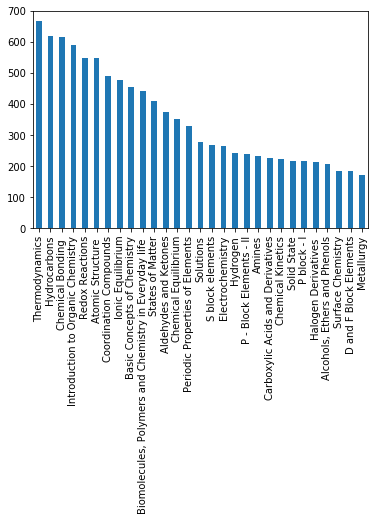

In [3]:
trainDF.label.value_counts().plot(kind="bar")

### Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8220 2055


#### Label Encoding
Label encoding is not needed for sklearn classifiers, as they are all capable of mutli-class classification, and handle label encoding automatically. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

For non-sklearn models like NNs or XGB, we need to do label encoding

In [5]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
valid_y = encoder.transform(valid_y)
valid_y[0:5]

array([ 7, 17, 17, 25,  3])

### Glove vectors
Loading GloVe embeddings from Standford dataset : http://www-nlp.stanford.edu/data/glove.840B.300d.zip


In [6]:
## Source - https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle
# load the GloVe vectors in a dictionary:
# create a map of words to vectors

embeddings_index = {}
f = open('glove.840B.300d.txt', 'r', encoding='utf8', errors = 'ignore')

for line in tqdm(f):     ## tqdm adds a progress bar
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:57, 9233.55it/s]

Found 2195892 word vectors.


In [7]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [8]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_x)]
xvalid_glove = [sent2vec(x) for x in tqdm(valid_x)]

100%|██████████| 2055/2055 [00:00<00:00, 2753.96it/s]


In [9]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

### Trying LSTM on GloVe features
Source : https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

In [10]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [11]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(train_y)
yvalid_enc = np_utils.to_categorical(valid_y)

In [12]:
### No of classes in the last layer
len(ytrain_enc[0])

29

In [13]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(29))                       ## No of classes to predict
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [14]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Train on 8220 samples, validate on 2055 samples
Epoch 1/5
8220/8220 [==============================] - 2s 296us/step - loss: 2.3883 - acc: 0.3635 - val_loss: 1.5812 - val_acc: 0.5679
Epoch 2/5
8220/8220 [==============================] - 1s 177us/step - loss: 1.5792 - acc: 0.5507 - val_loss: 1.3918 - val_acc: 0.6005
Epoch 3/5
8220/8220 [==============================] - 1s 146us/step - loss: 1.3473 - acc: 0.6033 - val_loss: 1.3246 - val_acc: 0.6331
Epoch 4/5
8220/8220 [==============================] - 1s 126us/step - loss: 1.2004 - acc: 0.6489 - val_loss: 1.2862 - val_acc: 0.6345
Epoch 5/5
8220/8220 [==============================] - 1s 174us/step - loss: 1.0841 - acc: 0.6791 - val_loss: 1.2839 - val_acc: 0.6355


#### Much higher validation accuracy than what we've seen with other algorithms with a very simple network and no hyper-param tuning

In [15]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(train_x) + list(valid_x))
xtrain_seq = token.texts_to_sequences(train_x)
xvalid_seq = token.texts_to_sequences(valid_x)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [16]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 7454/7454 [00:00<00:00, 183329.87it/s]


In [17]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(29))                            ## Num of classes to predict
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Train on 8220 samples, validate on 2055 samples
Epoch 1/100
8220/8220 [==============================] - 23s 3ms/step - loss: 3.2783 - acc: 0.0775 - val_loss: 3.1759 - val_acc: 0.1606
Epoch 2/100
8220/8220 [==============================] - 20s 2ms/step - loss: 3.0812 - acc: 0.1416 - val_loss: 2.7582 - val_acc: 0.2209
Epoch 3/100
8220/8220 [==============================] - 20s 2ms/step - loss: 2.7614 - acc: 0.1981 - val_loss: 2.4427 - val_acc: 0.2740
Epoch 4/100
8220/8220 [==============================] - 21s 3ms/step - loss: 2.5809 - acc: 0.2431 - val_loss: 2.2399 - val_acc: 0.3187
Epoch 5/100
8220/8220 [==============================] - 21s 3ms/step - loss: 2.4335 - acc: 0.2791 - val_loss: 2.0511 - val_acc: 0.3796
Epoch 6/100
8220/8220 [==============================] - 23s 3ms/step - loss: 2.3018 - acc: 0.3180 - val_loss: 1.9711 - val_acc: 0.4024
Epoch 7/100
8220/8220 [==============================] - 20s 2ms/step - loss: 2.2162 - acc: 0.3491 - val_loss: 1.9034 - val_acc: 0.4175


In [ ]:
## Adding early stopping
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(29))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Train on 8220 samples, validate on 2055 samples
Epoch 1/100
8220/8220 [==============================] - 54s 7ms/step - loss: 3.2037 - acc: 0.1035 - val_loss: 2.8400 - val_acc: 0.1776
Epoch 2/100
8220/8220 [==============================] - 58s 7ms/step - loss: 2.7388 - acc: 0.2090 - val_loss: 2.3560 - val_acc: 0.2993
Epoch 3/100
8220/8220 [==============================] - 61s 7ms/step - loss: 2.4353 - acc: 0.2810 - val_loss: 2.1432 - val_acc: 0.3577
Epoch 4/100
7168/8220 [=========================>....] - ETA: 6s - loss: 2.2920 - acc: 0.3283

#### Effects of Dropout
We see that the training loss is higher than validation loss and,
training accuracy is lower than validation accuracy.

"Why is the training loss much higher than the testing loss?
A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.
Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss." - Source - Keras FAQs

In [ ]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(29))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

In [ ]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(29))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])